# Poisonous Mushroom Classification

In this project, I investigated properties of mushrooms. This classic dataset contains over 8000 examples, where each describes a mushroom by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. The feature space has been binarized. Look at the feature_names below to see all 126 binary names.

I started by running PCA to reduce the dimensionality from 126 down to 2 so that I can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once I projected the data to 2 dimensions, I experimented with clustering using k-means and density estimation with Gaussian mixture models (GMM). Finally, I trained a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.



In [24]:
%matplotlib inline

import urllib.request as urllib2 # For python3 
import itertools 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.decomposition import PCA as PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LogNorm
from itertools import permutations  
from itertools import product  


In [25]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

Load feature names.

In [26]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))
print(feature_names)

Loaded feature names:  126
['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote', 'odor=fishy', 'odor=foul', 'odor=musty', 'odor=none', 'odor=pungent', 'odor=spicy', 'gill-attachment=attached', 'gill-attachment=descending', 'gill-attachment=free', 'gill-attachment=notched', 'gill-spacing=close', 'gill-spacing=crowded', 'gill-spacing=distant', 'gill-size=broad', 'gill-size=narrow', 'gill-color=black', 'gill-color=brown', 'gill-color=buff', 'gill-color=chocolate', 'gill-color=gray', 'gill-color=green', 'gill-color=orange', 'gill-color=pink', 'gill-color=purple', 'gill-col

Load data. The dataset is sparse, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [27]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


### Part 1:

Do a principal components analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].  Also show a lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.

Notes:
* You can use `PCA` to produce a PCA analysis.

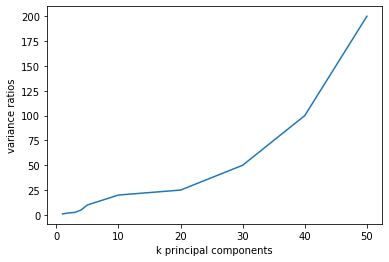

In [29]:
def P1():
    
    #Principal components (k in list)
    components = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
    
    #Create empty list to store variation ratios
    store = np.empty(len(components))
    
    #for loop to do PCA on each component value in list
    for i in components:
        pca = PCA(n_components = i)
        pca.fit_transform(train_data)
        variance_ratio = pca.explained_variance_ratio_
        
    #Plot components vs variance ratios
    plt.plot(components, store)
    plt.xlabel('k principal components')
    plt.ylabel('variance ratios')
    plt.show()

P1()

### Part 2:

PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and show as a square scatterplot. Show the positive (poisonous) examples in red and the negative (non-poisonous) examples in green. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Notes:
* You can use `PCA` to produce a PCA analysis.

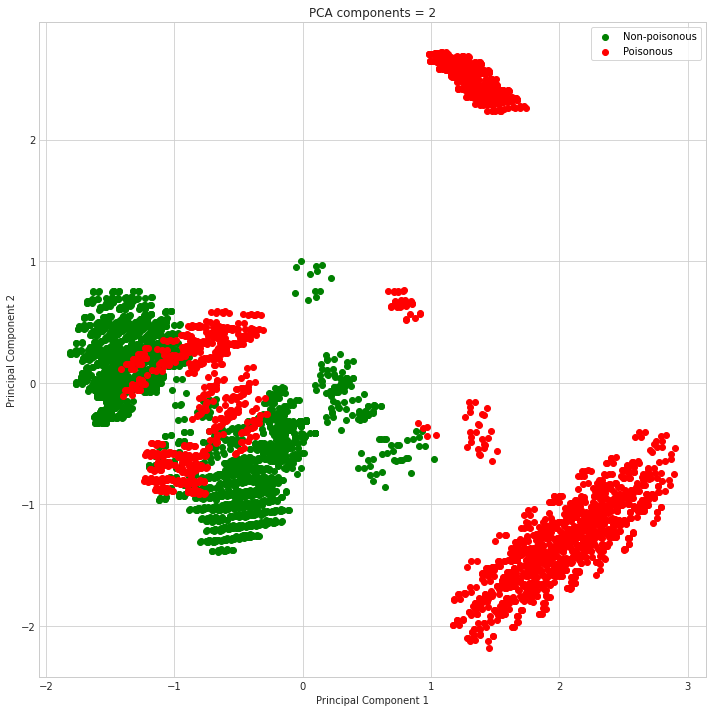

In [62]:
def P2():

    #Create PCA model and fit on training data 
    pca = PCA(n_components = 2)
    y_pca = pca.fit_transform(train_data)
    
    #Create plot of 2 PCA components, label with red - poisonous, green - nonpoisonous 
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize = (10,10))
        for lab, col in zip((0, 1),
                            ('green', 'red')):
            plt.scatter(y_pca[train_labels==lab, 0],
                        y_pca[train_labels==lab, 1],
                        label=lab,
                        c=col)
    #Plot        
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA components = 2')
    plt.legend(["Non-poisonous", "Poisonous"], loc='upper right')
    plt.tight_layout()
    plt.show()
        
P2()

### Part 3:

Fit a k-means cluster model with 6 clusters over the 2d projected data. As in part 2, show as a square scatterplot with the positive (poisonous) examples in red and the negative (non-poisonous) examples in green.  For each cluster, mark the centroid and plot a circle that goes through the cluster's example that is most distant from the centroid.

Notes:
* You can use `KMeans` to produce a k-means cluster analysis.
* You can use `linalg.norm` to determine distance (dissimilarity) between observations.

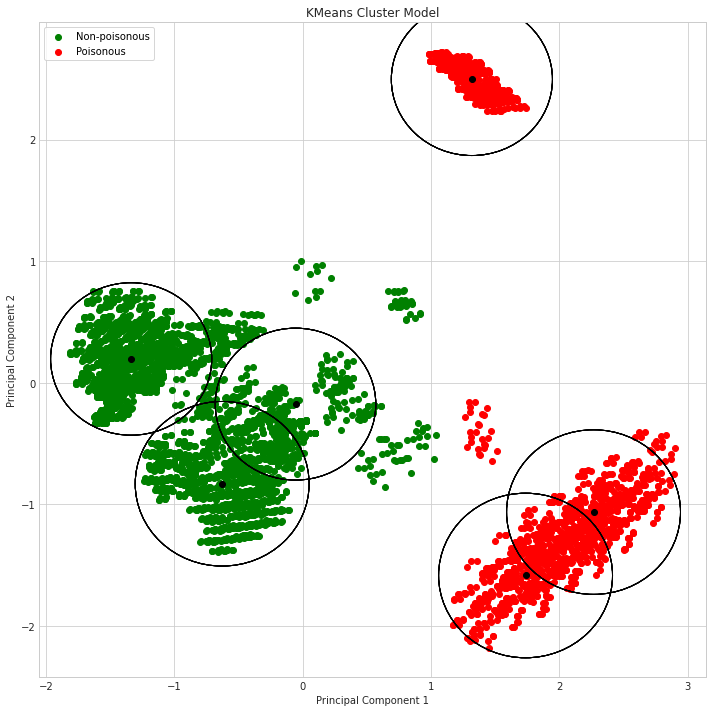

In [31]:
def P3():
    
    #Create PCA model 
    pca = PCA(n_components = 2)
    y_pca = pca.fit_transform(train_data)
    
    #Create kmeans clustering model 
    kmeans = KMeans(n_clusters=6, random_state=0)
    y_kmeans = kmeans.fit(y_pca)
    kmeans_predict = kmeans.predict(y_pca)
    kmeans_labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    #Create plot of 2 PCA components, label with red - poisonous, green - nonpoisonous, plot clusters
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize = (10, 10))
        for lab, col in zip((0, 1, 2, 3, 4, 5),
                           ('green', 'red', 'green', 'red', 'green', 'red')):
            plt.scatter(y_pca[kmeans_predict==lab, 0],
                        y_pca[kmeans_predict==lab, 1],
                        label=lab,
                        c=col)
    #Create empty lists for cluster distance and maximum cluster distance
    cluster_dist = []
    max_cluster_dist = []
    
    #for loop to find radius of circles by each cluster center
    for i in np.arange(6):
        for j in y_pca[kmeans_predict==i]:
            dist = np.linalg.norm(np.subtract(j, centers[i]))
            cluster_dist.append(dist)
            max_cluster_dist.append(max(cluster_dist))   
        for k in np.arange(6):
            circle = plt.Circle((centers[k][0], centers[k][1]), max_cluster_dist[k], fill = False)
            plt.gcf().gca().add_artist(circle)
    
    #Plot cluster centers 
    plt.scatter(centers[:,0], centers[:,1], c='black')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('KMeans Cluster Model')
    plt.legend(["Non-poisonous", "Poisonous"], loc='upper left')
    plt.tight_layout()
    plt.show()


P3()

### Part 4:

Fit Gaussian mixture models for the positive (poisonous) examples in your 2d projected data. Vary the number of mixture components from 1 to 4 and the covariance matrix type 'spherical', 'diag', 'tied', 'full' (that's 16 models).  Show square plots of the estimated density contours presented.

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `contour` in combination with other methods to plot contours, like in this example: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
* You can use `contour` without the `norm` and `levels` parameters. 

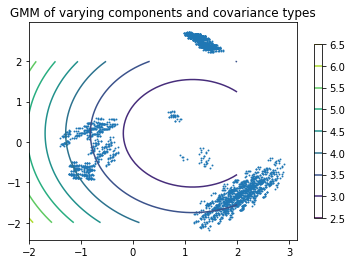

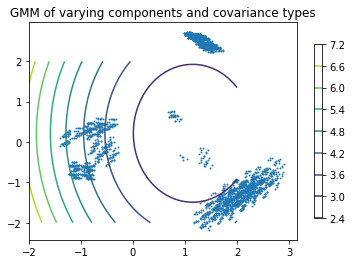

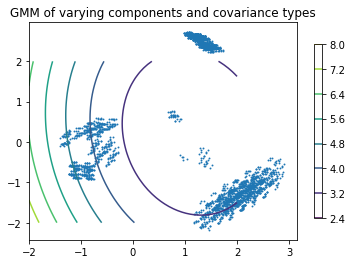

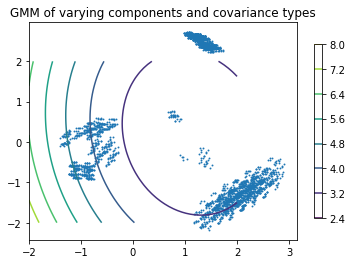

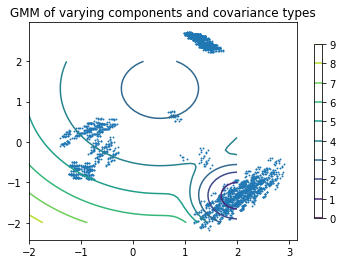

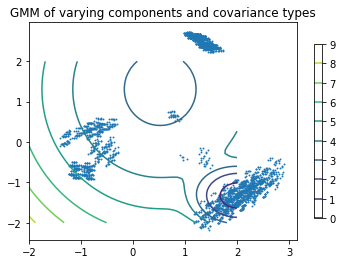

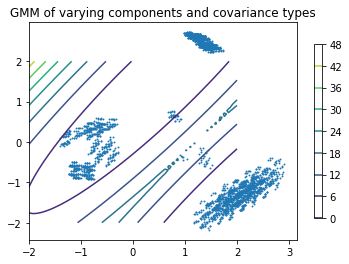

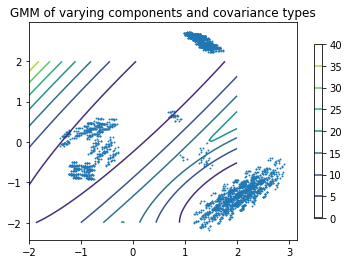

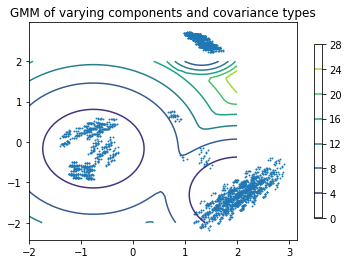

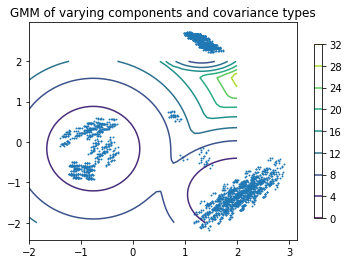

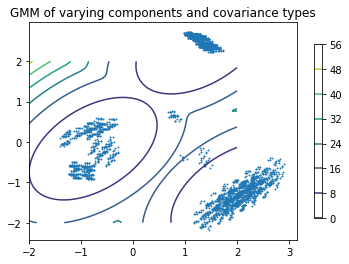

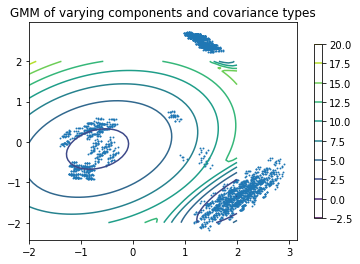

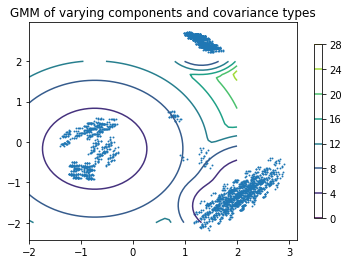

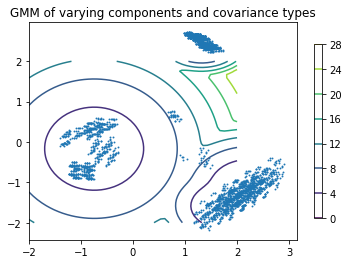

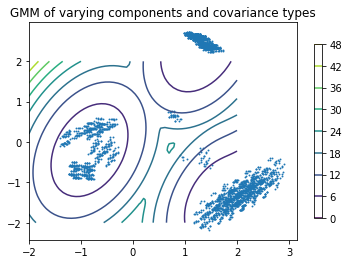

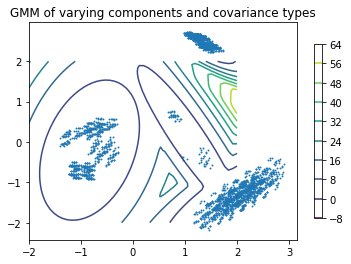

In [32]:
def P4():
    
    #List of components and types of covariance 
    components = [1, 2, 3, 4]
    covariance = ['spherical', 'diag', 'tied', 'full']
    
    #List of combinations of each component value and type of covariance
    combinations = list(itertools.product(components, covariance))
    
    #Create PCA model
    pca = PCA(n_components = 2)
    y_pca = pca.fit_transform(train_data)
    
    #Positive/poisonous values in data 
    poisonous = y_pca[train_labels==1]

    #for loop using GMM to predict accuracy of poisonous labeling 
    for i in combinations:
        gm = GaussianMixture(n_components = i[0], covariance_type = i[1], random_state=12345)
        y_gm = gm.fit(poisonous)
        gm_predict = gm.predict(poisonous)
        
        # display predicted scores by model as a contour plot
        x = np.linspace(-2.0, 2.0)
        y = np.linspace(-2.0, 2.0)
        X, Y = np.meshgrid(x, y)
        XX = np.array([X.ravel(), Y.ravel()]).T
        Z = -gm.score_samples(XX)
        Z = Z.reshape(X.shape)
        
        CS = plt.contour(X, Y, Z)
        CB = plt.colorbar(CS, shrink=0.8, extend='both')
        plt.scatter(poisonous[:, 0], poisonous[:, 1], .8)
        plt.title('GMM of varying components and covariance types')
        plt.axis('tight')
        plt.show()
        
figure, axes = plt.subplots(nrows=4, ncols=4)
axes[0, 0].plot(x, y)

    
P4()

### Part 5:

Fit two Gaussian mixture models, one for the positive examples and one for the negative examples in your 2d projected data. Use 4 mixture components and full convariance for each model.  Predict the test example labels by picking the labels corresponding to the larger of the two models' probabilities.  What is the accuracy of you predictions on the test data?

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `GaussianMixture`'s `score_samples` method to find the probabilities.

In [33]:
def P5():

    #PCA Model 
    pca = PCA(n_components = 2)
    y_pca_train = pca.fit_transform(train_data)
    y_pca_test = pca.transform(test_data)
    
    #Positive examples GMM
    poisonous = y_pca_train[train_labels==1]
    
    #Negative examples GMM
    non_poisonous = y_pca_train[train_labels==0]
    
    #GMM Positives/Poisonous 
    gm_p = GaussianMixture(n_components = 4, covariance_type = 'full', random_state=12345)
    y_gm_p = gm_p.fit(poisonous)
    
    #GMM Negatives/Non-poisonous 
    gm_np = GaussianMixture(n_components = 4, covariance_type = 'full', random_state=12345)
    y_gm_np = gm_np.fit(non_poisonous)
    
    #Count of number of positives and negatives correct (baseline: start at 0)
    num_correct_p = 0
    num_correct_np = 0 
    
    #Run for loop to find maximum probabilities 
    for i in range(len(test_labels)):
        if ((y_gm_p.score_samples([y_pca_test[i]]) > y_gm_np.score_samples([y_pca_test[i]])) and test_labels[i] == 1): 
            num_correct_p = num_correct_p + 1 
        if ((y_gm_p.score_samples([y_pca_test[i]]) < y_gm_np.score_samples([y_pca_test[i]])) and test_labels[i] == 0): 
            num_correct_np = num_correct_np + 1 

    print('Accuracy of poisonous', num_correct_p / len(test_labels[test_labels == 1]))
    print('Accuracy of non-poisonous', num_correct_np / len(test_labels[test_labels == 0]))
    print('Total accuracy', (num_correct_p + num_correct_np) / len(test_labels))
    
P5()

Accuracy of poisonous 0.9345403899721448
Accuracy of non-poisonous 0.9778325123152709
Total accuracy 0.9501779359430605


### Part 6:

Run a series of experiments to find the Gaussian mixture model that results in the best accuracy with no more than 50 parameters.  Do this by varying the number of PCA components, the number of GMM components, and the covariance type.

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.


* For spherical, diag, and full covariance types:
  * number of parameters = (number of parameters per gmm component * number of gmm components - 1) * number of classes
  * number of parameters per gmm component includes all the means plus all the non-zero, non-duplicated values in the covariance matrix plus the mixing weight
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter


* To calculate the number of parameters for tied covariance type:
  * number of parameters = (number of parameters per class - 1) * number of classes
  * number of parameters per class includes all the means and mixing weights for all the gmm components plus all the non-zero, non-duplicated values in the one shared covariance matrix
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter

In [34]:
def P6():
    
    #Number of classes = 2, poisonous and nonpoisonous 
    num_classes = 2 
    
    #List of covariances 
    covariance = ['spherical', 'diag', 'tied', 'full']
    
    #Highest accuracy will be added here (baseline: start at 0)
    highest_accuracy = 0
    
    #Accuracies for spherical, diag, and full covariance types 
        #num_param_per_gmm = gmm_means + cov_matrix + gmm_mix_weights 
        #num_param_not_tied = (num_param_per_gmm * num_gmm_components - 1) * num_classes
    
    #Accuracies for tied covariance type 
        #num_param_per_class = (gmm_means + gmm_mix_weights) + cov_matrix 
        #num_param_tied = (num_param_per_class - 1) * num_classes
    
    #Loop for PCA components 
    for pca_component in range(1, 25):
        pca = PCA(n_components = pca_component)
        y_pca_train = pca.fit_transform(train_data)
        y_pca_test = pca.transform(test_data)

        #Positive examples GMM
        poisonous = y_pca_train[train_labels==1]
        #Negative examples GMM
        non_poisonous = y_pca_train[train_labels==0]
        
        #Loop for GMM covariance types 
        for gmm_component in range(1, 25):
            
            for cov_type in covariance:
                num_parameters = 0
                
                if cov_type == 'spherical':
                    num_parameters = (pca_component * gmm_component + gmm_component) * 2
                
                elif cov_type == 'diag': 
                    num_parameters = (pca_component * gmm_component + pca_component * gmm_component) * 2
                
                elif cov_type == 'full':
                    num_parameters = (pca_component * gmm_component + pca_component * (pca_component - 1) * gmm_component) * 2
                    
                elif cov_type == 'tied':
                    num_parameters = (pca_component * gmm_component + pca_component * (pca_component - 1)) * 2
                    
                if num_parameters < 50:
            
                    #GMM Positives/Poisonous 
                    gm_p = GaussianMixture(n_components = gmm_component, covariance_type = cov_type, random_state=12345)
                    y_gm_p = gm_p.fit(poisonous)
    
                    #GMM Negatives/Non-poisonous 
                    gm_np = GaussianMixture(n_components = gmm_component, covariance_type = cov_type, random_state=12345)
                    y_gm_np = gm_np.fit(non_poisonous)
                
                    #Count of number of cases correct (baseline: start at 0)
                    num_correct = 0
                
                    for i in range(len(test_labels)):
                        if ((y_gm_p.score_samples([y_pca_test[i]]) > y_gm_np.score([y_pca_test[i]])) and test_labels[i] == 1):
                            num_correct = num_correct + 1

                        if ((y_gm_p.score_samples([y_pca_test[i]]) < y_gm_np.score([y_pca_test[i]])) and test_labels[i] == 0):
                            num_correct = num_correct + 1

                    if highest_accuracy < num_correct / len(test_labels):
                        best_param = (pca_component, gmm_component, cov_type, num_parameters, num_correct / len(test_labels))
                        highest_accuracy = num_correct / len(test_labels)

        print ("Processed: PCA = %d, GMM = (%d,%s), Parameters = %d, Accuracy = %f" % (pca_component, gmm_component, cov_type, num_parameters, num_correct / len(test_labels)))

    print ("Best result: PCA = %d, GMM = (%d,%s), Parameters = %d, Accuracy = %f" % best_param)

P6()

Processed: PCA = 1, GMM = (24,full), Parameters = 48, Accuracy = 0.911032
Processed: PCA = 2, GMM = (24,full), Parameters = 192, Accuracy = 0.958185
Processed: PCA = 3, GMM = (24,full), Parameters = 432, Accuracy = 0.956406
Processed: PCA = 4, GMM = (24,full), Parameters = 768, Accuracy = 0.957295
Processed: PCA = 5, GMM = (24,full), Parameters = 1200, Accuracy = 0.963523
Processed: PCA = 6, GMM = (24,full), Parameters = 1728, Accuracy = 0.967972
Processed: PCA = 7, GMM = (24,full), Parameters = 2352, Accuracy = 0.973310
Processed: PCA = 8, GMM = (24,full), Parameters = 3072, Accuracy = 0.968861
Processed: PCA = 9, GMM = (24,full), Parameters = 3888, Accuracy = 0.966192
Processed: PCA = 10, GMM = (24,full), Parameters = 4800, Accuracy = 0.968861
Processed: PCA = 11, GMM = (24,full), Parameters = 5808, Accuracy = 0.974199
Processed: PCA = 12, GMM = (24,full), Parameters = 6912, Accuracy = 0.913701
Processed: PCA = 13, GMM = (24,full), Parameters = 8112, Accuracy = 0.878114
Processed: PC